Get tasks where nnInteractive performs the worst
e.g : MR_BraTS-T2,  CT_Aorta, MR_WMH_T1

In [1]:
from src.config import config
import pandas as pd
import os
import numpy as np
import nibabel as nib
import sys
sys.path.append('/nfs/norasys/main/src/python')
from DPX_core import *

img_dir = os.path.join(config["DATA_DIR"], "3D_val_npz")
gts_dir = os.path.join(config["DATA_DIR"], "3D_val_gt_interactive_seg")
current_dir = os.getcwd()

Loaded configuration for machine: nora


In [7]:
# get list of cases from the segfm3d dataset
import random
segfm3d_stats_bycase = pd.read_csv(os.path.join(current_dir, "ic_segmentation/notebooks/segfm3d_stats_bycase.csv"))
task_prefix = "CT_Aorta" #"CT_LungMask" # "MR_BraTS-T2" # "MR_WMH_T1"  
case_name_list = segfm3d_stats_bycase[segfm3d_stats_bycase["CaseName"].str.startswith(task_prefix)]["CaseName"].tolist()
print(len(case_name_list))

case_subset = random.sample(case_name_list, 1)
print(case_subset)

5
['CT_Aorta_AortaK12']


In [8]:

for case_filename in case_subset:
    print("Processing case: ", case_filename)


    img_path = os.path.join(img_dir, case_filename + ".npz")
    img_data = np.load(img_path)
    img = img_data["imgs"]
    img_spacing = img_data["spacing"]
    img_spacing = img_spacing[::-1]  # reverse spacing order
    gt_path = os.path.join(gts_dir, case_filename + ".npz")
    gt_data = np.load(gt_path)
    gt = gt_data["gts"]
    gt_spacing = gt_data["spacing"]
    gt_spacing = gt_spacing[::-1]  # reverse spacing order
    print("Image shape: ", img.shape)
    print("GT shape: ", gt.shape)

    # convert to nifty and save in nora project
    # juypter session needs to be run from a project that has access to the destination project

    img_nifti = nib.Nifti1Image(img, affine=np.diag(np.append(img_spacing, 1)))
    nib.save(img_nifti, os.path.join(config["RESULTS_DIR"], case_filename + "_img.nii.gz"))
    gt_nifti = nib.Nifti1Image(gt, affine=np.diag(np.append(gt_spacing, 1)))
    nib.save(gt_nifti, os.path.join(config["RESULTS_DIR"], case_filename + "_gt.nii.gz"))


    project_name = "camaret___in_context_segmentation"
    
    # add files from command line 
    !nora -p {project_name} -a --patients_id {case_filename} {os.path.join(config["RESULTS_DIR"], case_filename + "_img.nii.gz")}
    !nora -p {project_name} -a --patients_id {case_filename} {os.path.join(config["RESULTS_DIR"], case_filename + "_gt.nii.gz")} --addtag mask 
    #file_names = [os.path.join(config["RESULTS_DIR"], case_filename + "_img.nii.gz"), os.path.join(config["RESULTS_DIR"], case_filename + "_gt.nii.gz")]
    #DPX_addFiles(project_name,file_names)

Processing case:  CT_Aorta_AortaK12
Image shape:  (139, 512, 512)
GT shape:  (139, 512, 512)
Finished adding 1 files         
Finished adding 1 files         


In [52]:
img_spacing

array([0.977, 0.977, 3.   ])

In [4]:
# Evaluate 3Dino 
# ~/notebooks/repos$ git clone https://github.com/AICONSlab/3DINO.git

sys.path.append('../../repos/3DINO')  
sys.path.append('repos/3DINO')  

from dinov2.eval.setup import build_model_for_eval
from dinov2.configs import load_and_merge_config_3d
import torch

/nfs/norasys/notebooks/camaret/repos/3DINO/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/nfs/norasys/notebooks/camaret/repos/3DINO/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/nfs/norasys/notebooks/camaret/repos/3DINO/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [5]:
import huggingface_hub 
huggingface_hub.login()


In [6]:
huggingface_hub.hf_hub_download(repo_id="AICONSlab/3DINO-ViT", filename="3dino_vit_weights.pth")

'/home/dpxuser/.cache/huggingface/hub/models--AICONSlab--3DINO-ViT/snapshots/8a00a2bb14becb3fbe955064837322a3217f7ac0/3dino_vit_weights.pth'

In [7]:
config_file = 'train/vit3d_highres'
pretrained_weights = '/home/dpxuser/.cache/huggingface/hub/models--AICONSlab--3DINO-ViT/snapshots/8a00a2bb14becb3fbe955064837322a3217f7ac0/3dino_vit_weights.pth'  # adjust this to local path

cfg = load_and_merge_config_3d(config_file)
model = build_model_for_eval(cfg, pretrained_weights)

print(model)

DinoVisionTransformer3d(
  (patch_embed): PatchEmbed3d(
    (proj): Conv3d(1, 1024, kernel_size=(16, 16, 16), stride=(16, 16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): BlockChunk(
      (0-5): 6 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        

In [8]:
# the minimal preprocessing of the input image should be normalizing it to have values ranging between -1 and 1
# shape is batch size, channels, and spatial dims
example_img = torch.randn(1, 1, 112, 112, 112).cuda()

# for example: 
# normalize 99.95% percentile to 1 and 0.05% percentile to -1, then clip to -1, 1
min_val = torch.quantile(example_img, 0.0005)
max_val = torch.quantile(example_img, 0.9995)
example_img = (example_img - min_val) / (max_val - min_val)
example_img = torch.clip(example_img * 2 - 1, -1, 1)

print(example_img.max(), example_img.min())

out = model(example_img)

tensor(1., device='cuda:0') tensor(-1., device='cuda:0')


In [9]:
print(out.shape)

torch.Size([1, 1024])


run the visualisation : 

PYTHONPATH=. python dinov2/eval/vis_pca.py   --config-file 'dinov2/configs/train/vit3d_highres.yaml'   --output-dir '/nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/results/3DINO/pca'   --pretrained-weights '/home/dpxuser/.cache/huggingface/hub/models--AICONSlab--3DINO-ViT/snapshots/8a00a2bb14becb3fbe955064837322a3217f7ac0/3dino_vit_weights.pth'   --image-path '/nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/results/MR_BraTS-T2f_bratsgli_0006_img.nii.gz'   --vis-type 'mhsa'   --input-type 'sliding_window'

In [10]:
from torch.nn.functional import interpolate
import matplotlib.pyplot as plt
from matplotlib import animation

def vis_pca(pth, resize=1.0):
    # load original image, and first 4 PCA components
    img = torch.tensor(nib.load(f'{pth}/orig.nii.gz').get_fdata())
    pca0 = torch.tensor(nib.load(f'{pth}/nifti_0.nii.gz').get_fdata())
    pca1 = torch.tensor(nib.load(f'{pth}/nifti_1.nii.gz').get_fdata())
    pca2 = torch.tensor(nib.load(f'{pth}/nifti_2.nii.gz').get_fdata())
    pca3 = torch.tensor(nib.load(f'{pth}/nifti_3.nii.gz').get_fdata())
    h, w, d = img.shape
    
    # background can usually be masked out with a simple threshold (may arbitrarily need to be > threshold or < threshold)
    # adjust this for your image!
    bg_mask = (pca0 > 0.5).float()
    
    # create PCA volume and normalize each component
    pca_vol = torch.stack([pca1, pca2, pca3], dim=3)
    pca_min = pca_vol.view(-1, 3).min(dim=0).values.reshape(1, 1, 1, -1)
    pca_max = pca_vol.view(-1, 3).max(dim=0).values.reshape(1, 1, 1, -1)
    pca_vol = (pca_vol - pca_min) / (pca_max - pca_min)
    
    # can make volumes smaller for faster visualization
    bg_mask = interpolate(
        bg_mask.unsqueeze(0).unsqueeze(0), size=(int(h*resize), int(w*resize), int(d*resize)), mode='nearest'
    ).bool()[0, 0]
    pca_vol = interpolate(
        pca_vol.unsqueeze(0).permute(0, 4, 1, 2, 3), size=(int(h*resize), int(w*resize), int(d*resize)), mode='nearest'
    )[0].permute(1, 2, 3, 0)
    img = interpolate(
        img.unsqueeze(0).unsqueeze(0), size=(int(h*resize), int(w*resize), int(d*resize)), mode='trilinear'
    )[0, 0]
    
    # set the PCA volume background to white
    pca_vol[bg_mask, :] = 1.0
    
    # this can improve PCA visualization contrast, adjust for your image!
    pca_vol[pca_vol < 0.4] = 0
    return img.numpy(), pca_vol.numpy()

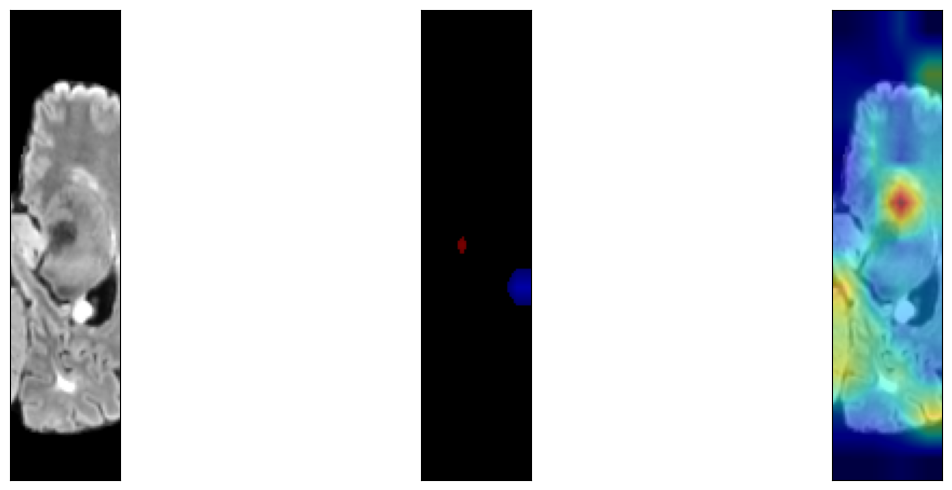

In [41]:
train_case = "MR_BraTS-T2f_bratsgli_0006"

z = 70  # z-axis slice to visualize
mhsa_ind = 13  # MHSA head index for vis

# create volumes, adjust these paths to your created folders!
img, pca_vol = vis_pca(os.path.join(config["RESULTS_DIR"], f"3DINO_features/{train_case}/mhsa"), resize=1.0)
mhsa_vol = nib.load(os.path.join(config["RESULTS_DIR"], f"3DINO_features/{train_case}/mhsa/nifti_{mhsa_ind}.nii.gz")).get_fdata()
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax in fig.axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# display volumes
axs[0].imshow(np.rot90(img[:, :, z]), cmap='gray')
axs[1].imshow(np.rot90(pca_vol[:, :, z, :]))
axs[2].imshow(np.rot90(img[:, :, z]), cmap='gray')
axs[2].imshow(np.rot90(mhsa_vol[:, :, z]), cmap='jet', alpha=0.5)

plt.tight_layout()
plt.show()

In [42]:
# get all files in os.path.join(config["RESULTS_DIR"], f"3DINO/mhsa/nifti_{mhsa_ind}.nii.gz")

mhsa_files = []
for f in os.listdir(os.path.join(config["RESULTS_DIR"], f"3DINO_features/{train_case}/mhsa")):
    if f.startswith(f"nifti_") and f.endswith(".nii.gz"):
        mhsa_files.append(os.path.join(config["RESULTS_DIR"], f"3DINO_features/{train_case}/mhsa", f))
# create an array to hold all mhsa volumes
mhsa_vols = []
for f in mhsa_files:
    vol = nib.load(f).get_fdata()
    mhsa_vols.append(vol)
mhsa_vols = np.stack(mhsa_vols, axis=3)  # shape is H, W, D, num_heads
print(mhsa_vols.shape)

gt = nib.load(os.path.join(config["RESULTS_DIR"], f"{train_case}_gt.nii.gz")).get_fdata()
print(gt.shape)

(51, 218, 182, 16)
(51, 218, 182)


In [43]:
# train xgboost model to predict segmentation from mhsa features
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score

X = mhsa_vols.reshape(-1, mhsa_vols.shape[3])  # shape is num_voxels, num_heads
y = gt.flatten()  # shape is num_voxels
# --- IGNORE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Calculate class weights
unique, counts = np.unique(y_train, return_counts=True)
total = len(y_train)
class_weights = {cls: total / (len(unique) * count) for cls, count in zip(unique, counts)}

# Use sample_weight parameter
sample_weights = np.array([class_weights[label] for label in y_train])

model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=len(np.unique(y))
)
model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("XGBoost segmentation accuracy: ", accuracy)
# --- IGNORE ---    

# balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("XGBoost balanced accuracy: ", balanced_acc)


XGBoost segmentation accuracy:  0.9963478759365054
XGBoost balanced accuracy:  0.9837519071238077


In [44]:
# evaluate on a different case
test_case = "MR_BraTS-T2f_bratsgli_0009"
test_mhsa_files = []
for f in os.listdir(os.path.join(config["RESULTS_DIR"], f"3DINO_features/{test_case}/mhsa")):
    if f.startswith(f"nifti_") and f.endswith(".nii.gz"):
        test_mhsa_files.append(os.path.join(config["RESULTS_DIR"], f"3DINO_features/{test_case}/mhsa", f))
# create an array to hold all mhsa volumes
test_mhsa_vols = []
for f in test_mhsa_files:
    vol = nib.load(f).get_fdata()
    test_mhsa_vols.append(vol)
test_mhsa_vols = np.stack(test_mhsa_vols, axis=3)  # shape is H, W, D, num_heads
print(test_mhsa_vols.shape)

test_gt = nib.load(os.path.join(config["RESULTS_DIR"], f"{test_case}_gt.nii.gz")).get_fdata()
print(test_gt.shape)



(90, 218, 182, 16)
(90, 218, 182)


In [45]:
X_test_case = test_mhsa_vols.reshape(-1, test_mhsa_vols.shape[3])  # shape is num_voxels, num_heads
y_test_case = test_gt.flatten()  # shape is num_voxels
y_test_case_pred = model.predict(X_test_case)
balanced_acc_case = balanced_accuracy_score(y_test_case, y_test_case_pred)
print("XGBoost balanced accuracy on test case: ", balanced_acc_case)

XGBoost balanced accuracy on test case:  0.2


In [ ]:
# Get all test cases with 3DINO features (excluding the training case)
features_dir = os.path.join(config["RESULTS_DIR"], "3DINO_features")
all_cases = [d for d in os.listdir(features_dir) if os.path.isdir(os.path.join(features_dir, d))]
test_cases = [c for c in all_cases if c != train_case]
print(f"Found {len(test_cases)} test cases: {test_cases}")

project_name = "camaret___in_context_segmentation"

for test_case in test_cases:
    print(f"\nProcessing test case: {test_case}")
    
    # Load MHSA features for this test case
    test_mhsa_files = []
    mhsa_dir = os.path.join(config["RESULTS_DIR"], f"3DINO_features/{test_case}/mhsa")
    for f in os.listdir(mhsa_dir):
        if f.startswith("nifti_") and f.endswith(".nii.gz"):
            test_mhsa_files.append(os.path.join(mhsa_dir, f))
    
    test_mhsa_vols = []
    for f in test_mhsa_files:
        vol = nib.load(f).get_fdata()
        test_mhsa_vols.append(vol)
    test_mhsa_vols = np.stack(test_mhsa_vols, axis=3)
    
    # Load ground truth
    test_gt = nib.load(os.path.join(config["RESULTS_DIR"], f"{test_case}_gt.nii.gz")).get_fdata()
    
    # Predict
    X_test_case = test_mhsa_vols.reshape(-1, test_mhsa_vols.shape[3])
    y_test_case = test_gt.flatten()
    y_test_case_pred = model.predict(X_test_case)
    
    # Calculate balanced accuracy
    balanced_acc_case = balanced_accuracy_score(y_test_case, y_test_case_pred)
    print(f"XGBoost balanced accuracy on {test_case}: {balanced_acc_case:.4f}")
    
    # Reshape prediction back to original volume shape and save as NIfTI
    y_test_case_pred_vol = y_test_case_pred.reshape(test_gt.shape)
    
    # Load the original image to get spacing info
    test_img_path = os.path.join(config["RESULTS_DIR"], f"{test_case}_img.nii.gz")
    test_img_nifti = nib.load(test_img_path)
    
    # Create NIfTI with same affine as original image
    pred_nifti = nib.Nifti1Image(y_test_case_pred_vol.astype(np.float32), affine=test_img_nifti.affine)
    pred_path = os.path.join(config["RESULTS_DIR"], f"{test_case}_3dino_pred.nii.gz")
    nib.save(pred_nifti, pred_path)
    print(f"Saved prediction to: {pred_path}")
    
    # Add to NORA project with 3dino_pred tag
    !nora -p {project_name} -a --patients_id {test_case} {pred_path} --addtag 3dino_pred
    print(f"Added {test_case}_3dino_pred.nii.gz to project with tag '3dino_pred'")